# Dog breed classifier 

## Loding the libraries 

>We Load __pytorch, fastai__ for our neural  networks and __matplotlib__ for some plotting and __pandas__ for data frame processing under the hood

__I like the FASTAI beacuse -__
 
  - It gives me the pre built fuction of cutting edge research ideas.
  
  - Quick fuction for learning plots and inbuilt docs in jupyter.
  
  - Also a very modular classes so I can customize the network with my own ideas.
  
  - It's very easy and fast to set a datapipline to give data to our models and spliting traing and validation sets in FastAi.

In [38]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import random

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Path('/home/nbuser/Bomotix/data/train')

In [4]:
pd.read_csv(str(path)+'/labels.csv').head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


__We use following things -__

 - ImagImageItemList.from_csv to to get Images list frrm csv
 - random_split_by_pct to take out some data from valdition from our traing dataset
 - label_from_df to provide label column in datframe to provide labels to our dataset pipline
 - add_test_folder to add test folder in our Databunch to later use it to predict an submit results.

>__Here we use random_split_by_pct which takes care of same distribution of classes in both train and validation set if we using our own split function we should make sure the data class label dstributuion is same in both train and validation set.__

In [5]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'labels.csv', folder='train', suffix='.jpg')
       .random_split_by_pct(0.1)
       .label_from_df(['breed'])
       .add_test_folder())

## Data augmentation

>Most of the time data augmenatation improve the accuracy of our model it helps the model to learn mainly in following two ways -

    1. Provide some more examples if we have less traning data.
    2. It's provide the input data variations and hepls to regularize our model weights.

In [6]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

here we use __Roatation, zoom , lighting and some other__ augmentation techniques which is very easy to use in FastAi.



__Here keep mind that we start with low resolution 224X224 than our data set full resolution which may go upto 300X300 but it's intentional and the why behibd this revelead later.__


In [7]:
data = (src.transform(tfms, size=224)
        .databunch(bs=32).normalize(imagenet_stats))

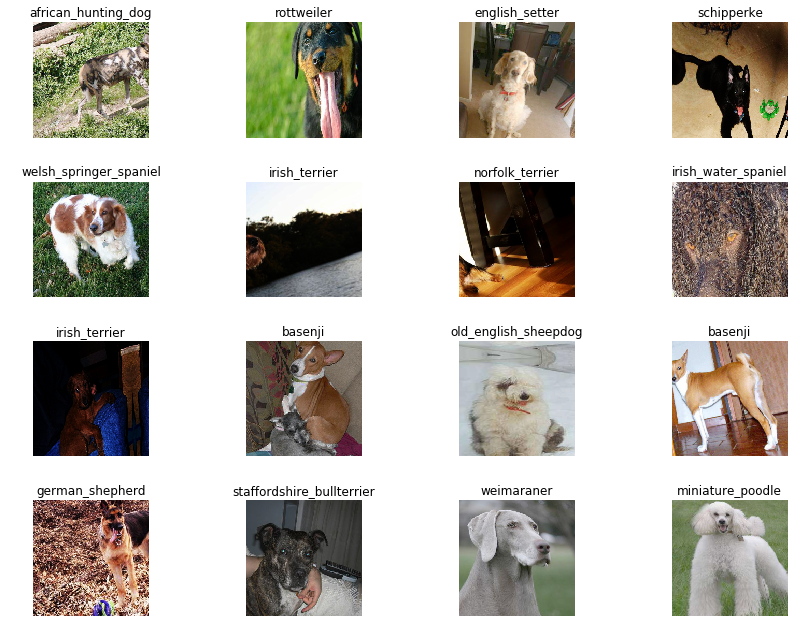

In [8]:
data.show_batch(rows=4, figsize=(12,9))

## Transfer Learning 
   > - It's a good situation to take help from the transfer learning beacuse imagenet has dog category and diffrent other which are somehow give some knowledge to our classifier.
   
__We are using resnet101 for I also used resnet50 but resnet101 perform better beacuse skip connection always help in general  deep learning models__

In [10]:
arch = models.resnet101

>   
- Here create_cnn is fucntion which connect our databunch to our models and we provide metrics as accuracy to track the learning during training.


In [11]:
learn = create_cnn(data, arch, metrics=[accuracy])

In [9]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


## Learning rate finder 

> __Learning rate finder__ is my faviourate metod find a good learning rate for model which is most crucial parameter for the neural network.

- Here we start from a low learning rate and increase the learning rat slowly to plot loss and learning rate curve to find a good learning rate

#### LR finder Plot

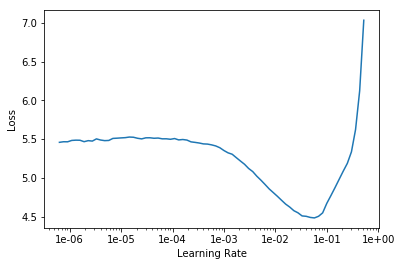

In [12]:
learn.recorder.plot()

> Here we can see that out learning rate Our loss starts increasing after 0.01. We take the learning before some points where loss starts increase because learning rate around inmima in this plot may lead to divergence.

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr/5))

epoch,train_loss,valid_loss,accuracy
1,1.662396,0.659344,0.806262
2,1.034068,0.440678,0.860078
3,0.789692,0.388720,0.883562
4,0.640174,0.341394,0.890411
5,0.563620,0.339939,0.886497


> __Here we freezed the weights of fromer layer and traned only fully connected layers.__

## 1cycle policy
<img src='https://sgugger.github.io/images/art5_full_schedule.png'>

_The main idea behind this to find good flat minimas rather in less time -_

__1. Learning rate -__
- Start with lower learning rate to take gradeint steps in right direction at first.
- Increase learning rate linearly to a maximum learning rate which is usually 10*minimum learning rate an then decrease it to minimum learning rate
- In this way in middle of the traning where usally make very slow process in loss funtion vlaeey area or sadel points jump into a flatter minimas.
- we decrease the learning rate gain to find a good minima in a flatter minima.


__2. Momentum -__
- we keep momentum low in the middle so the greadient can more dpends on larger stpe and quickly escape from steeper loss surface and go into flatter areas of loss surface.


__In this way we find good flatter minima and with high learning rates we get this minima in few epocs besies od all this we get inbuilt regularization with this method.__

> __To more closely understand this method and inbuilt regularization thing check out My this blog__
> - [SuperConvergence — Quick training with inbuilt regularization](https://towardsdatascience.com/superconvergence-with-inbuilt-regularization-49f914173cd8) 

In [15]:
learn.save('stage-1-rn0101');

In [16]:
learn.unfreeze()

#### Now we unfreeze th whole network and find the learnign wtih same lr Finder

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


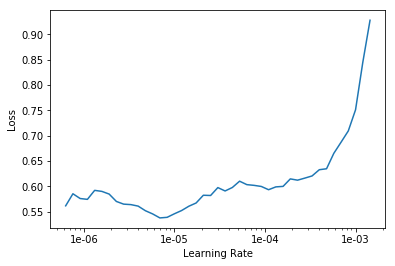

In [17]:
learn.lr_find()
learn.recorder.plot()

## Discriminative layer training

It's also an successful experiment to train different layers with diffrent learning rates.

> - We are trying to tune all layers weights in our network after unfreezing but we know that basic features would not much change but as we moves towrds last layers the more amount of tuning or weight adjust required.
> - So for an example with slice(1e-3, 1e -5) in fit_one_cycle the first layers will get 1e - 5 learning rate . The other layers will get learning rates that are equally spread between those two. Multiplicatively equal. If there were three layers there would be (1e - 5), (1e - 4) and (1e-3). Equal multiples each time. 

In this way we can better tune our netowrking in comparision to giving same learning rate to all the layers.


In [18]:
learn.fit_one_cycle(5, slice(1e-5, 1e-5/5))

epoch,train_loss,valid_loss,accuracy
1,0.545011,0.332964,0.890411
2,0.515804,0.335719,0.889432
3,0.521707,0.337585,0.886497
4,0.493153,0.334683,0.887476
5,0.498245,0.334089,0.890411


In [19]:
learn.save('stage-2-rn101');

## Doing the same process with increase resolution

> Now we increase our databunch size to 300 and again train with this high resolution images this learning learn more detailed features in hi-res images but the low-res tarined network weights provide a good surface to learn hi-res features instead of care about lower detailed features.

__Because of the above reason we train netwrok with lower resolution first__

In [33]:
data = (src.transform(tfms, size=300)
        .databunch(bs=32).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 300, 300])

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


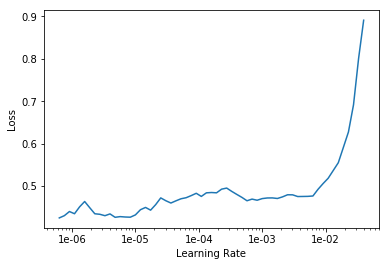

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(5, slice(1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.463305,0.328891,0.888454
2,0.518162,0.316827,0.897260
3,0.464832,0.312909,0.896282
4,0.374850,0.305023,0.904110
5,0.378514,0.304740,0.909002


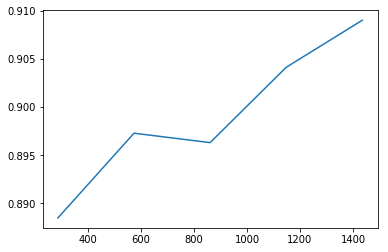

In [26]:
learn.recorder.plot_metrics()

In [28]:
learn.load('stage-1-300-rn101');

In [29]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


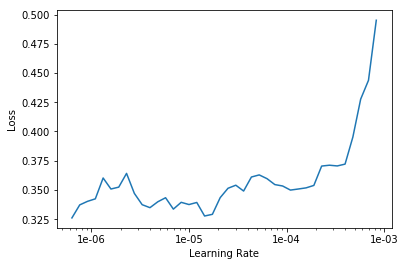

In [25]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(1e-4, 1e-6))

epoch,train_loss,valid_loss,accuracy
1,0.317920,0.312065,0.903131
2,0.391081,0.346924,0.891389
3,0.347846,0.334702,0.900196
4,0.304004,0.322721,0.903131
5,0.290346,0.317670,0.902153


In [13]:
learn.save('stage-2-300-rn101')

## Analyse Our trained Model
> Many times this step is so crucial to find where our perform or good but this thing so under-rated but it's important to analyse our trained because -
> - See which part of image pixel or which feature model learn to identify a praticular category
> - See the top losses to understand where should we can improve more for an example if model fails on a specific category or an specific type angle of image so we can imrove on that area.
> - See In which category our model is most confused

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

### Most consfused categories

- Same type breeds variation dogs are mostly missclassified as we can see below -

In [16]:
interp.most_confused(min_val=2)

[('eskimo_dog', 'siberian_husky', 6),
 ('appenzeller', 'entlebucher', 3),
 ('australian_terrier', 'silky_terrier', 3),
 ('great_pyrenees', 'kuvasz', 3),
 ('lhasa', 'tibetan_terrier', 3),
 ('scottish_deerhound', 'irish_wolfhound', 3),
 ('silky_terrier', 'australian_terrier', 3),
 ('walker_hound', 'english_foxhound', 3)]

### top losses

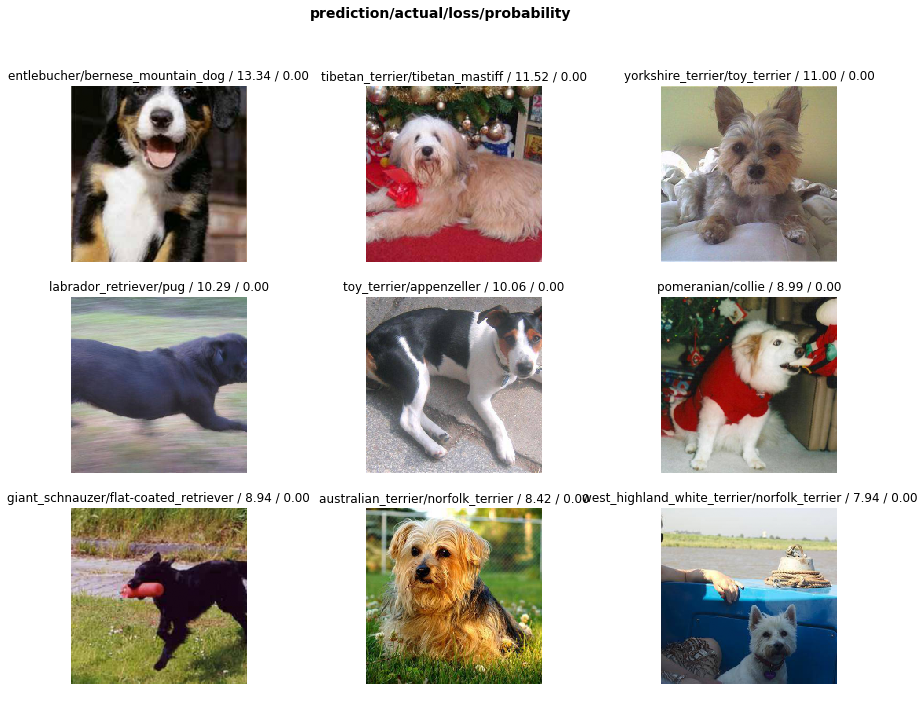

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

> From analyzing the model faliure exaples we found the __model confused in betwwen diffrent types of terrier dogs and diffrent type of hound dogs__

### CAM maps 

> _Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class._

- Here we can create some __plot Cam maps to see whether our model getting right feature signal or fitted some uncessary noisy signal features.__

Category toy_terrier

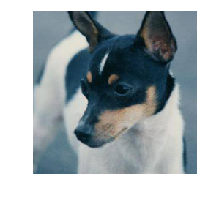

In [19]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [20]:
from fastai.callbacks.hooks import *

In [21]:
m = learn.model.eval();

In [45]:
def Cam_heat_map(idx):
    x,y = data.valid_ds[idx]
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    hook_a,hook_g = hooked_backward(xb)
    acts  = hook_a.stored[0].cpu()
    avg_acts = acts.mean(0)
    _,ax = plt.subplots()
    ax.set_title(y)
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.6, extent=(0,300,300,0),
              interpolation='bilinear', cmap='magma');
    

In [46]:
def hooked_backward(xb,cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

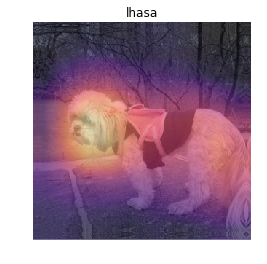

In [47]:
Cam_heat_map(random.randint(0,len(learn.data.valid_ds)))

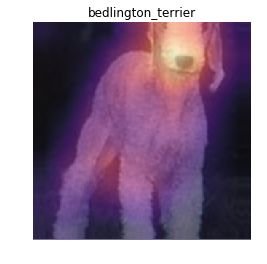

In [48]:
Cam_heat_map(random.randint(0,len(learn.data.valid_ds)))

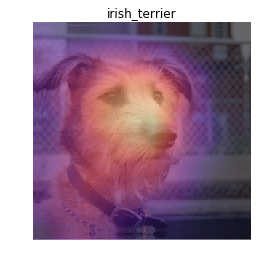

In [50]:
Cam_heat_map(random.randint(0,len(learn.data.valid_ds)))

### Cam insights
> - As we can see IN the Class activation maps the our neural network main foucs is on the face of dogs(red-yellow part).
> - After that body is important which came in blue area.
> - And enviorment around the dogs not affect the dog breed so nueral network not activate the surrounding of the dog represented as gray area.

## Test time augmentation
> New thing I learn about is using test time augmentation which many time increase the accuracy little bit for the kaggle competitions.
In this we use diffrent augmentation techniques on testset and submit the average predictions.


In [32]:
preds = learn.TTA(ds_type=DatasetType.Test)

In [33]:
df = pd.DataFrame(data=preds[0].numpy(),columns=learn.data.train_ds.y.classes)

In [34]:
df['id'] = learn.data.test_ds.items

In [35]:
cols = df.columns.tolist()
df = df[[cols[-1]] + cols[:-1]] 

In [36]:
import os

In [37]:
def name_id(x):
    return os.path.basename(x).split('.')[0]

In [38]:
df.id = df.id.apply(name_id)

In [39]:
df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,27ee48039c475345d1d24103d0b4fcb9,9.461844e-04,7.808002e-07,5.843990e-05,5.372251e-07,5.374254e-05,8.782970e-05,2.560938e-06,1.655960e-05,1.012480e-05,...,2.503458e-03,3.424183e-03,3.158865e-05,3.452040e-06,1.527238e-04,3.158214e-06,1.024821e-05,9.899863e-05,3.659955e-06,4.497215e-05
1,23e3de07d79b125aa21651f6d2bb972b,1.017433e-02,5.474577e-04,2.424293e-03,5.986999e-05,5.726581e-05,1.168266e-04,1.333725e-04,4.186438e-05,1.412841e-04,...,3.218238e-05,7.209216e-05,1.396749e-03,1.954293e-04,5.546891e-04,1.301525e-04,3.008043e-05,7.352439e-04,1.368674e-03,5.074456e-04
2,9fbc55434909504c4c47fa6ee36fb0b3,2.102377e-09,5.015693e-06,1.697257e-07,8.089497e-09,1.744125e-09,1.146857e-08,2.018011e-10,4.109320e-11,1.183619e-09,...,1.924706e-09,2.215322e-11,1.730872e-10,2.693088e-09,6.591701e-09,1.663316e-08,2.691659e-10,1.495714e-07,3.906335e-11,6.413378e-10
3,35fc6ed2368af10f2712b8f0de79ebc2,1.452659e-05,1.790325e-06,1.313017e-03,2.272963e-06,1.153866e-04,3.302041e-03,3.763741e-06,8.977429e-04,2.651317e-05,...,1.221100e-05,4.489867e-03,7.538171e-06,3.391143e-05,3.467604e-06,3.150766e-05,2.270561e-04,2.940979e-04,3.740577e-05,1.309280e-05
4,af4e22d6628e3e7707c5a3bf350e34ed,2.393681e-03,3.119892e-04,1.169586e-04,9.403993e-06,1.585280e-05,1.230106e-04,7.577830e-05,1.975990e-05,3.808983e-05,...,5.814253e-04,1.010345e-05,7.102308e-05,3.397025e-06,1.334099e-04,4.264721e-05,2.185125e-05,2.651357e-05,1.217390e-05,2.274623e-03


In [40]:
df.to_csv('dog_sub1.csv',index=False)

## With this we get score 0.389 which.